In [1]:
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#TODO: Fix random seeds for reproducibility

In [2]:
class OscillatoryGridCell1D(nn.Module):
    def __init__(self, *args, randomize=True, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.shift = self._init_param(0, lambda x: nn.init.uniform_(x, 0, 1) if randomize else x)
        self.scaling = self._init_param(1, lambda x: nn.init.trunc_normal_(x, 1, 1.0, 0.1, 10) if randomize else x)

    def forward(self, position):
        """Encode a point on a cartesian 1D axis to a grid cell activation."""
        # We scale only the coordinates to keep the shift in the [0, 1] range
        position = self.scaling * position - self.shift
        return (torch.cos(2 * torch.pi * position) + 1) / 2
    
    def _init_param(self, default_value, init_function):
        param = torch.tensor(default_value, dtype=self.dtype, device=self.device)
        init_function(param)
        param = nn.Parameter(param, requires_grad=True)
        return param

In [3]:
class GridCellArray1D(nn.Module):
    def __init__(self, n_neurons, *args, dtype=torch.float32, device="cpu", **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        assert n_neurons > 0, "Number of neurons must be positive."
        self.neurons = nn.ModuleList([OscillatoryGridCell1D(dtype=dtype, device=device) for _ in range(n_neurons)])

    def forward(self, X):
        """Encode a point on a cartesian 2D plane to a vector of grid cell neuron activations."""
        return torch.stack([cell(X) for cell in self.neurons], dim=-1).squeeze(dim=0)

In [4]:
grid_cell = OscillatoryGridCell1D(randomize=False, dtype=torch.float32, device=device)

In [5]:
grid_cell(0)

tensor(1., grad_fn=<DivBackward0>)

In [6]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

grid_cell(positions)

tensor([1.0000, 0.5000, 0.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000, 1.0000],
       grad_fn=<DivBackward0>)

In [7]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

In [8]:
randomized_grid_cell = OscillatoryGridCell1D(randomize=True, dtype=torch.float32, device=device)

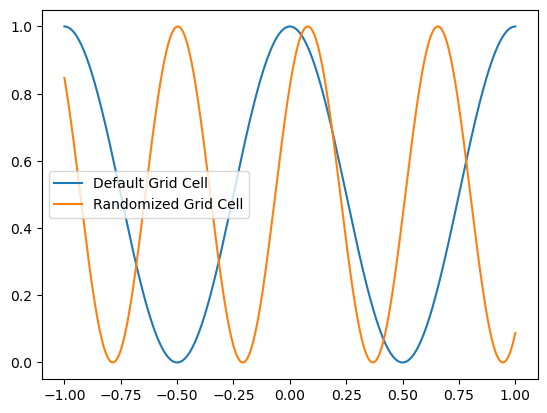

In [9]:
plt.plot(positions, grid_cell(positions).detach().numpy(), label="Default Grid Cell")
plt.plot(positions, randomized_grid_cell(positions).detach().numpy(), label="Randomized Grid Cell")
plt.legend()

In [10]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)

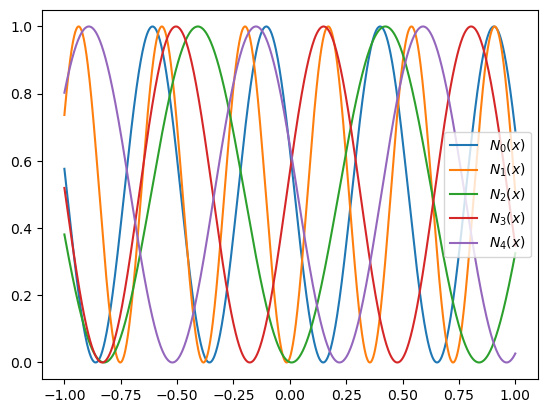

In [11]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()

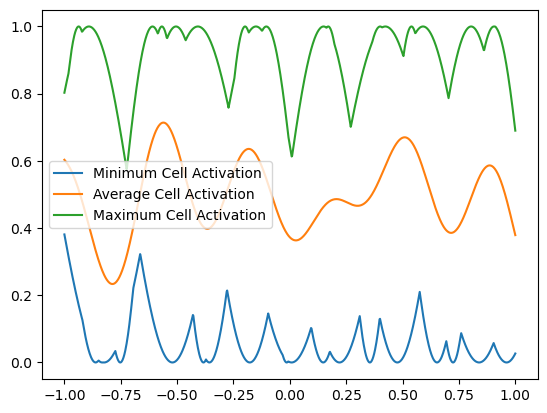

In [12]:
plt.plot(positions, grid_cell_array(positions).min(axis=-1).values.detach().numpy(), label="Minimum Cell Activation")
plt.plot(positions, grid_cell_array(positions).mean(axis=-1).detach().numpy(), label="Average Cell Activation")
plt.plot(positions, grid_cell_array(positions).max(axis=-1).values.detach().numpy(), label="Maximum Cell Activation")

plt.legend()

In [13]:
class LinearDecoder1D(nn.Module):
    def __init__(self, grid_cell_array, *args, dtype=torch.float32, device="cpu", weighted=True, **kwargs):
        super().__init__(*args, **kwargs)

        self.device = device
        self.dtype = dtype

        self.n_neurons = len(grid_cell_array.neurons)
        
        self.grid_cell_array = grid_cell_array
        # We don't need need bias because we will be inferring the predicted position from the maximum activation value
        log_weights = torch.ones(self.n_neurons, dtype=dtype, device=device)
        if weighted:
            nn.init.normal_(log_weights, 0, 1)
        self.log_weights = nn.Parameter(log_weights, requires_grad=weighted)
        self.weight_softmax = nn.Softmax(dim=-1)
        self.position_softmax = nn.Softmax(dim=-1)
    
    def forward(self, true_activations, position_estimates):
        """Decode the neuron representation"""
        assert (true_activations.shape[-1] == self.n_neurons), "The number of neurons in the grid cell array must match the number of neurons used the true activations."
        assert len(true_activations.shape) <= 2, "The true activations must be a tensor of shape (n_true_positions, n_neurons)."
        if len(true_activations.shape) == 1:
            true_activations = true_activations.reshape(1, self.n_neurons)

        # 1. Compute the activation for possible X estimations
        estimated_activations = self.grid_cell_array(position_estimates)

        # 2. Multiply it by the activations for the true positions (it will discriminate against the other positions)
        # TODO: Optimize this step using better vectorization technique
        if len(estimated_activations.shape) == 1:
            estimated_activations = estimated_activations.reshape(1, -1)
        discriminated_activations = (estimated_activations.expand(true_activations.shape[0], -1, -1).transpose(0, 1) * true_activations).transpose(0, 1)
        # 3. Compute the weighted sum using the decoder weights (the decoder will consider some neurons more "valuable" than others)
        decoded_activations = discriminated_activations @ self.weights()
        # Apply softmax to get the position probability distribution estimate
        position_probabilities = self.position_softmax(decoded_activations.reshape(true_activations.shape[0], -1))
        # 4. Find the position expectations by computing the weighted sum of the position estimations' probabilities
        position_expectations = position_probabilities @ position_estimates
        most_probable_positions = position_estimates[position_probabilities.argmax(dim=-1)]
        return position_probabilities, position_expectations, most_probable_positions
    
    def weights(self):
        # Note that we are using the softmax of the weights to enforce the weights to be positive and to sum up to 1
        return self.weight_softmax(self.log_weights)

In [14]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=False)
decoder.weights()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [15]:
true_x = torch.tensor([0.5], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([0.6623, 0.8917, 0.9189, 0.0123, 0.8592], grad_fn=<SqueezeBackward1>)

In [16]:
positions = torch.tensor([0.5], dtype=torch.float32, device=device)

position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)

print((true_activations.reshape(1, -1) ** 2).mean(dim=-1))

position_probabilities, position_expectations, most_probable_positions

tensor([0.5633], grad_fn=<MeanBackward1>)


(tensor([[1.]], grad_fn=<SoftmaxBackward0>),
 tensor([0.5000], grad_fn=<MvBackward0>),
 tensor([0.5000]))

In [17]:
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True)
decoder.weights()

tensor([0.2105, 0.1189, 0.3200, 0.2443, 0.1063], grad_fn=<SoftmaxBackward0>)

In [18]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.1151, 0.0940, 0.1244, 0.1237, 0.0948, 0.1103, 0.1393, 0.0939, 0.1046]],
        grad_fn=<SoftmaxBackward0>),
 tensor([-0.0066], grad_fn=<MvBackward0>),
 tensor([0.5000]))

In [19]:
true_x = torch.tensor([0, 0.5, 1, 10], dtype=torch.float32, device=device)
true_activations = grid_cell_array(true_x)
true_activations

tensor([[6.3410e-01, 1.4431e-02, 8.5446e-04, 5.6750e-01, 6.4586e-01],
        [6.6233e-01, 8.9173e-01, 9.1889e-01, 1.2333e-02, 8.5918e-01],
        [6.8998e-01, 5.0559e-01, 3.2521e-01, 3.4760e-01, 2.6677e-02],
        [9.9658e-01, 1.7458e-01, 2.3301e-03, 9.7651e-01, 3.3441e-01]],
       grad_fn=<SqueezeBackward1>)

In [20]:
positions = torch.tensor([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1], dtype=torch.float32, device=device)

decoder(true_activations, positions)

(tensor([[0.1148, 0.1056, 0.1166, 0.1060, 0.1151, 0.1095, 0.1087, 0.1159, 0.1079],
         [0.1151, 0.0940, 0.1244, 0.1237, 0.0948, 0.1103, 0.1393, 0.0939, 0.1046],
         [0.1132, 0.0992, 0.1243, 0.1103, 0.1055, 0.1139, 0.1172, 0.1054, 0.1110],
         [0.1148, 0.0995, 0.1259, 0.1004, 0.1151, 0.1132, 0.1042, 0.1177, 0.1093]],
        grad_fn=<SoftmaxBackward0>),
 tensor([-0.0023, -0.0066, -0.0002,  0.0004], grad_fn=<MvBackward0>),
 tensor([-0.5000,  0.5000, -0.5000, -0.5000]))

In [21]:
grid_cell_array = GridCellArray1D(5, dtype=torch.float32, device=device)
decoder = LinearDecoder1D(grid_cell_array, dtype=torch.float32, device=device, weighted=True)

N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(position_expectations)
print(most_probable_positions)

torch.Size([5, 1001])
tensor([0.0376, 0.0632, 0.0631, 0.0063, 0.0274], grad_fn=<MvBackward0>)
tensor([1.0000, 0.6800, 1.0000, 0.2360, 0.6700])


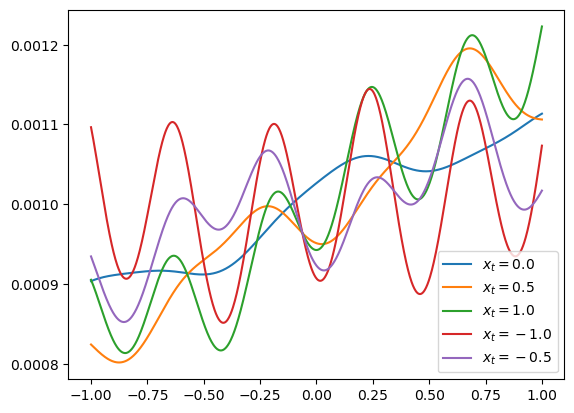

In [22]:
for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

In [23]:
def train(*, n_neurons=5, weighted_decoder=True, n_positions=1000, batch_size=100, n_epochs=100, learning_rate=0.01, verbose=True, dtype=torch.float32, device="cpu"):
    # Define the desired domain
    
    positions = torch.empty(n_positions, dtype=dtype, device=device)
    positions = torch.linspace(-1, 1, n_positions)
    #torch.nn.init.uniform_(positions, -1, 1)

    # Define the grid cell array and the decoder
    grid_cell_array = GridCellArray1D(n_neurons, dtype=dtype, device=device)
    decoder = LinearDecoder1D(grid_cell_array, dtype=dtype, device=device, weighted=weighted_decoder)

    # Define the optimizer
    optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    loss = 0

    for epoch in range(n_epochs):
        # Generate random positions for the epoch
        positions = positions[torch.randperm(n_positions, device=device)]
        for i in range(0, n_positions, batch_size):
            optimizer.zero_grad()
            # TODO: Use DataSet and DataLoader

            batch_positions = positions[i:i + batch_size]
            true_activations = grid_cell_array(batch_positions)
            position_probabilities, position_expectations, _ = decoder(true_activations, batch_positions)

            loss = 0

            # # Distance to the expected value (seems to be the worst)
            # # TODO: Use MSE loss from torch.nn
            # loss += ((position_expectations - batch_positions) ** 2).mean()
            
            # Variance (not the best but adds stability)
            loss += (((batch_positions.expand(batch_size, -1).T - batch_positions) ** 2).sum(dim=-1) * position_probabilities).mean()

            # Negative log probability for true positions: 
            loss -= torch.log(position_probabilities.diagonal()).sum()

            # # Regularize agaist decoder weight difference:
            # loss += (decoder.weights() ** 2).mean()
            

            loss.backward()
            optimizer.step()

        if verbose:
            true_activations = grid_cell_array(positions)
            _, _, most_probable_positions = decoder(true_activations, positions)
            loss = ((most_probable_positions - positions) ** 2).mean()

            print("Epoch {:3d} - Loss: {:.6f}".format(epoch + 1, loss.item()))
        

    return grid_cell_array, decoder

In [25]:
grid_cell_array, decoder = train(n_neurons=5, n_epochs=1000, n_positions=1001, batch_size=100, learning_rate=0.01, dtype=torch.float32, device=device)

Epoch   1 - Loss: 0.407335
Epoch   2 - Loss: 0.361152
Epoch   3 - Loss: 0.477156
Epoch   4 - Loss: 0.388250
Epoch   5 - Loss: 0.409846
Epoch   6 - Loss: 0.399390
Epoch   7 - Loss: 0.400553
Epoch   8 - Loss: 0.323247
Epoch   9 - Loss: 0.307660
Epoch  10 - Loss: 0.278764
Epoch  11 - Loss: 0.390176
Epoch  12 - Loss: 0.316883
Epoch  13 - Loss: 0.330418
Epoch  14 - Loss: 0.390229
Epoch  15 - Loss: 0.334974
Epoch  16 - Loss: 0.320228
Epoch  17 - Loss: 0.313090
Epoch  18 - Loss: 0.314694
Epoch  19 - Loss: 0.287625
Epoch  20 - Loss: 0.298591
Epoch  21 - Loss: 0.314625
Epoch  22 - Loss: 0.234502
Epoch  23 - Loss: 0.293984
Epoch  24 - Loss: 0.226528
Epoch  25 - Loss: 0.283935
Epoch  26 - Loss: 0.264791
Epoch  27 - Loss: 0.275896
Epoch  28 - Loss: 0.300238
Epoch  29 - Loss: 0.286309
Epoch  30 - Loss: 0.222434
Epoch  31 - Loss: 0.228995
Epoch  32 - Loss: 0.254239
Epoch  33 - Loss: 0.251463
Epoch  34 - Loss: 0.236233
Epoch  35 - Loss: 0.248734
Epoch  36 - Loss: 0.299239
Epoch  37 - Loss: 0.289205
E

In [26]:
decoder.weights()

tensor([0.1541, 0.1362, 0.2425, 0.1827, 0.2846], grad_fn=<SoftmaxBackward0>)

torch.Size([5, 1001])
tensor([ 0.0000,  0.5000,  1.0000, -1.0000, -0.5000])
tensor([-4.6730e-05, -8.2164e-03,  8.6043e-03, -1.0618e-02,  8.1962e-03],
       grad_fn=<MvBackward0>)
tensor([-0.7220,  0.5160,  0.8860, -0.9140, -0.5100])


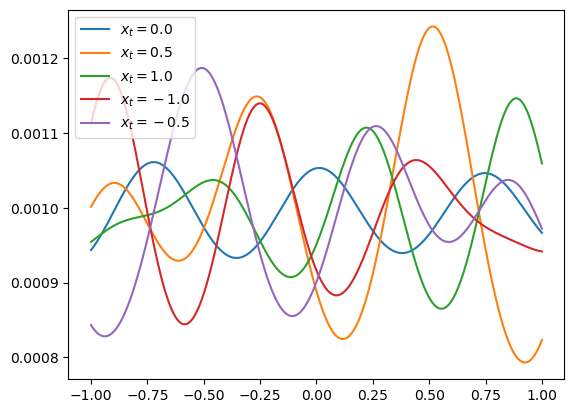

In [27]:
N = 1001
x_min, x_max = -1, 1

positions = torch.linspace(x_min, x_max, N, dtype=torch.float32, device=device)

true_positions = torch.tensor([0, 0.5, 1, -1, -0.5], dtype=torch.float32, device=device)

true_activations = grid_cell_array(true_positions)
position_probabilities, position_expectations, most_probable_positions = decoder(true_activations, positions)
print(position_probabilities.shape)
print(true_positions)
print(position_expectations)
print(most_probable_positions)

for i, true_position in enumerate(true_positions):
    plt.plot(positions, position_probabilities[i].detach().numpy(), label=f"$x_t={true_position}$")

plt.legend()

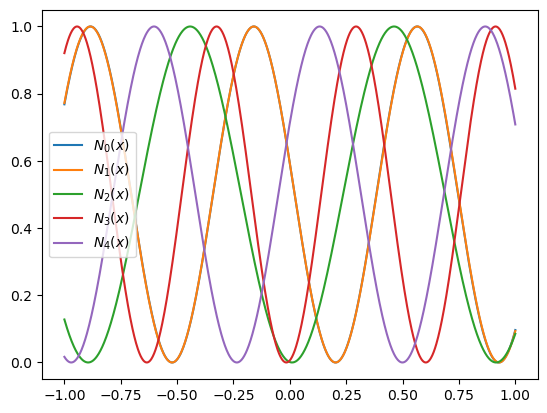

In [28]:
for i, neuron in enumerate(grid_cell_array.neurons):
    plt.plot(positions, neuron(positions).detach().numpy(), label=f"$N_{i}(x)$")

plt.legend()